In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
X_train = pd.read_csv("preprocessing_data.csv")

umist_data = pd.read_csv("umist_cropped.csv")

In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [4]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1

rnd_pca = PCA(n_components=d, svd_solver='randomized', random_state=123)

X_train_rpca = rnd_pca.fit_transform(X_train)

In [5]:
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [6]:
metrics_list = ['euclidean', 'minkowski', 'cosine', 'cityblock']      

In [7]:
max_clusters = 30  # Maximum number of clusters to test
results = {}
square_distances_matrix = []
clusters_res = []

Average linkage and euclidean metric: 

Number of clusters: 20
Silhouette Score: 0.27013891343725943


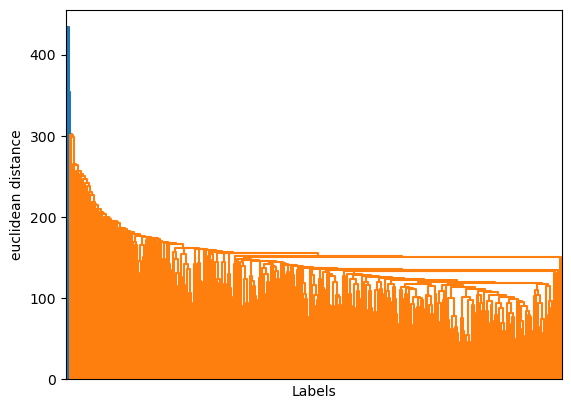

Average linkage and minkowski metric: 

Number of clusters: 20
Silhouette Score: 0.25539722628383293


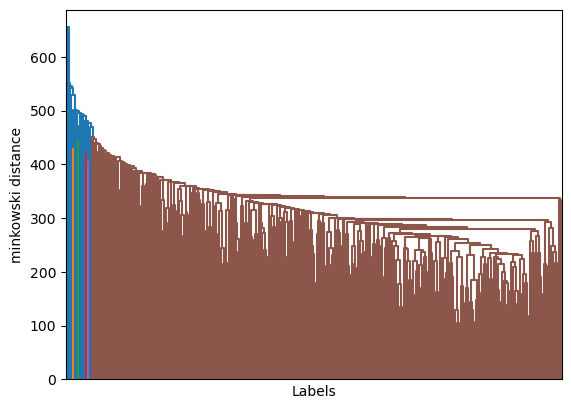

Average linkage and cosine metric: 

Number of clusters: 20
Silhouette Score: 0.10209252537012965


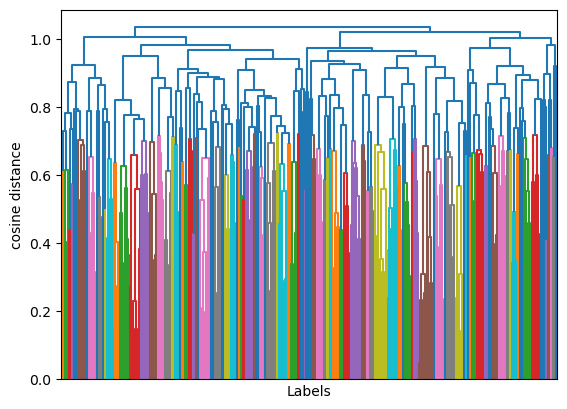

Average linkage and cityblock metric: 

Number of clusters: 20
Silhouette Score: 0.07219096531813002


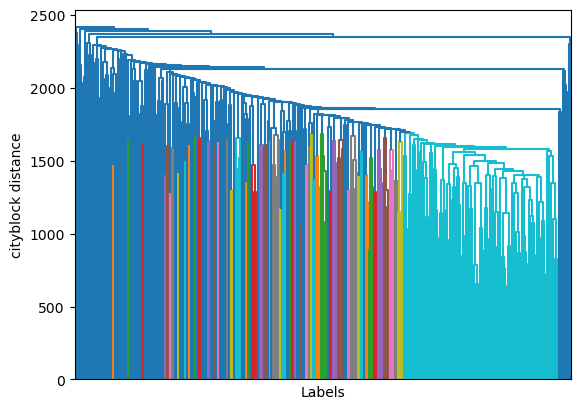

In [8]:
for m in metrics_list:
    print(f'Average linkage and {m} metric: \n')
    if m == 'minkowski':
        Y = pdist(X_train_rpca, metric=m, p=1.5)
    else:
        Y = pdist(X_train_rpca, metric=m)
        
    dist_matrix = squareform(Y)
        
    Z = linkage(Y, method='average')
    clusters = fcluster(Z, 20, criterion='maxclust')
    dendrogram(Z, no_labels= True)
    # Check the number of clusters
    num_clusters = len(set(clusters))
    square_distances_matrix.append(dist_matrix)
    clusters_res.append(clusters)
    print(f'Number of clusters: {num_clusters}')
    silhouette = metrics.silhouette_score(X_train, clusters, metric=m)
    print(f'Silhouette Score: {silhouette}')
    plt.xlabel("Labels")
    plt.ylabel(f'{m} distance')
    plt.show()

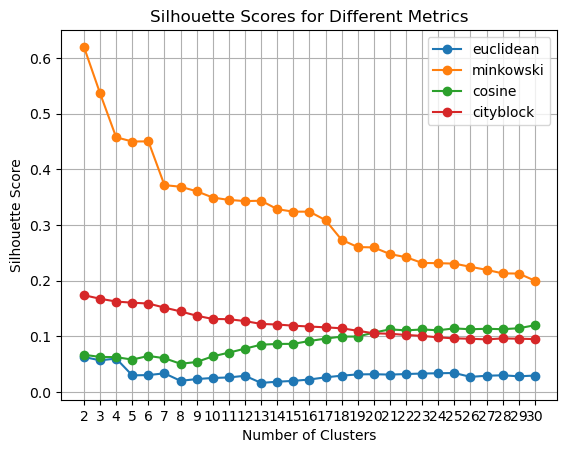

In [9]:
for metric in metrics_list:
    silhouette_scores = []
    
    # Iterate through the possible number of clusters
    for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
        # Compute pairwise distances
        if metric == 'minkowski':
            Y = pdist(X_train_rpca, metric=metric, p=1.5)
        else:
            Y = pdist(X_train_rpca, metric=metric)
        
        
        if metric in ['euclidean']:
            Z = linkage(Y, method='ward')
        else:
            Z = linkage(Y, method='average')

        # Create flat clusters
        clusters = fcluster(Z, n_clusters, criterion='maxclust')

        # Check the number of clusters formed
        num_clusters_formed = len(set(clusters))
        
        # Ensure that the number of clusters is valid
        if num_clusters_formed > 1:
            # Calculate silhouette score
            silhouette = metrics.silhouette_score(X_train_rpca, clusters, metric=metric)
            silhouette_scores.append(silhouette)
        else:
            silhouette_scores.append(-1)  # Append a negative score or None if not valid

    # Store results for the current metric
    results[metric] = silhouette_scores

    # Plotting
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label=metric)

# Plotting
plt.title("Silhouette Scores for Different Metrics")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, max_clusters + 1))
plt.legend()
plt.grid()
plt.show()

In [10]:
# Print optimal cluster numbers
for metric, scores in results.items():
    optimal_clusters = np.argmax(scores) + 2  # +2 because we start from 2 clusters
    max_score = scores[optimal_clusters - 2] if optimal_clusters - 2 >= 0 else -1
    if max_score > 0:
        print(f"Optimal number of clusters for {metric}: {optimal_clusters} with a silhouette score of {max_score:.3f}")
    else:
        print(f"Optimal number of clusters for {metric}: No valid clusters formed")

Optimal number of clusters for euclidean: 2 with a silhouette score of 0.063
Optimal number of clusters for minkowski: 2 with a silhouette score of 0.620
Optimal number of clusters for cosine: 30 with a silhouette score of 0.120
Optimal number of clusters for cityblock: 2 with a silhouette score of 0.174


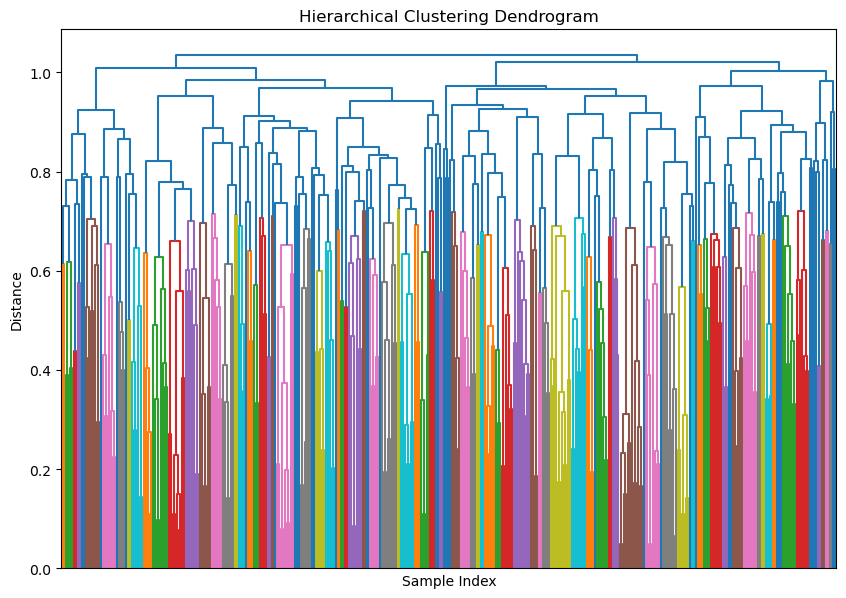

In [11]:
Y = pdist(X_train_rpca, metric='cosine')
        
# Perform hierarchical clustering using linkage
Z = linkage(Y, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, no_labels= True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [12]:
from scipy.cluster.hierarchy import fcluster

# Set a cutoff distance
cutoff_distance = 20  # Adjust this based on the dendrogram

# Get cluster labels
cluster_labels = fcluster(Z , cutoff_distance, criterion='maxclust')


print(np.unique(cluster_labels))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


Counter({5: 50, 6: 44, 12: 36, 3: 29, 10: 27, 14: 27, 17: 25, 16: 22, 2: 22, 4: 20, 1: 20, 11: 19, 15: 14, 7: 12, 13: 12, 18: 8, 9: 6, 8: 3, 20: 2, 19: 2})


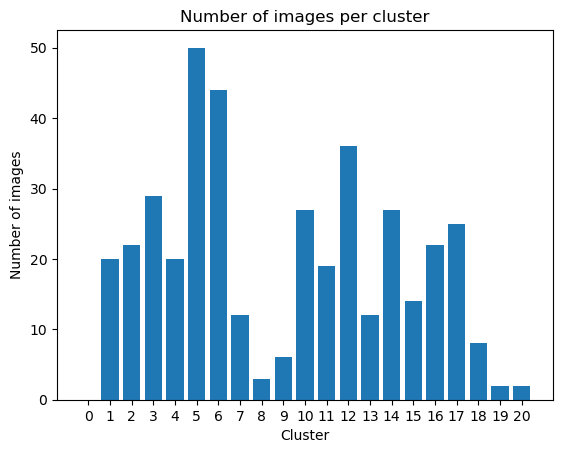

In [13]:
from collections import Counter

print(Counter(cluster_labels))

plt.bar(range(21), np.bincount(cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(21))
plt.show()

Counter({4: 50, 2: 44, 0: 36, 12: 29, 7: 27, 13: 27, 5: 25, 17: 22, 8: 22, 10: 20, 16: 20, 9: 19, 3: 14, 1: 12, 19: 12, 6: 8, 14: 6, 15: 3, 11: 2, 18: 2})


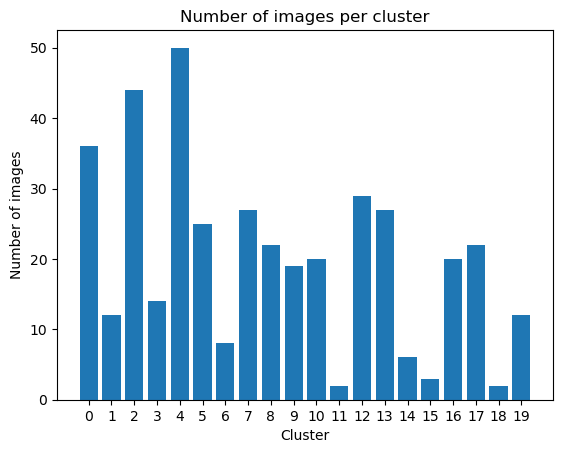

In [14]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=20, metric='cosine', linkage='average')
clustering.fit(X_train_rpca)
cluster_labels = clustering.labels_


from collections import Counter

print(Counter(cluster_labels))

plt.bar(range(20), np.bincount(clustering.labels_))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(20))
plt.show()

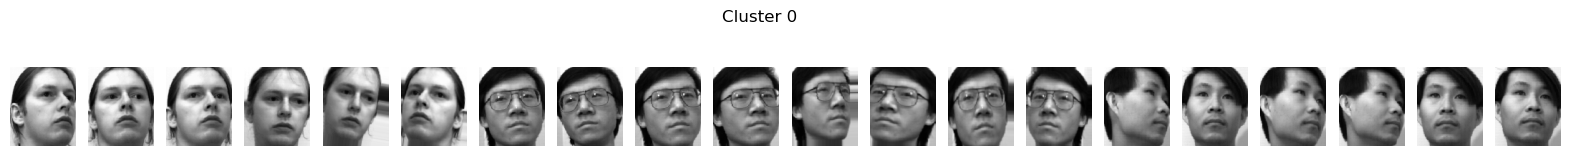

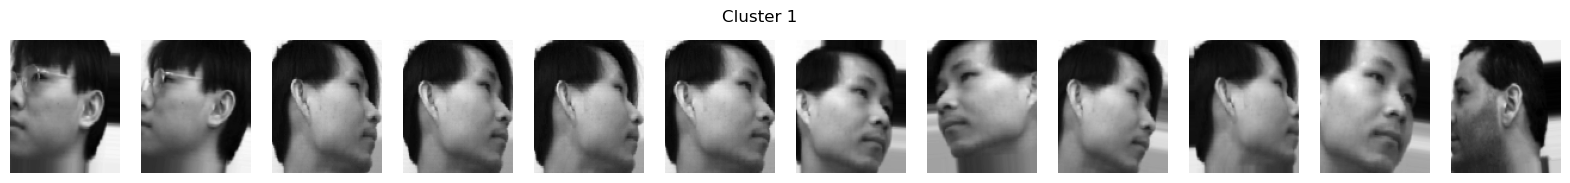

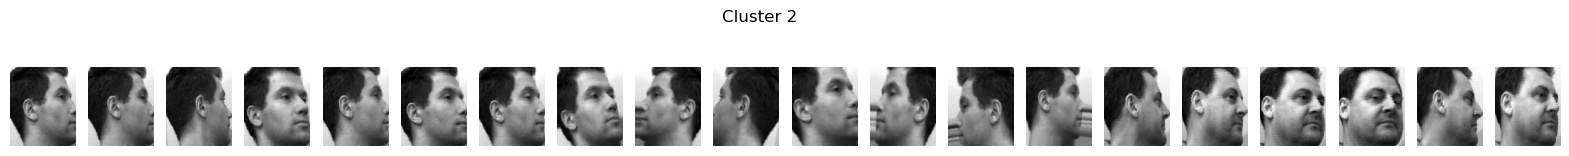

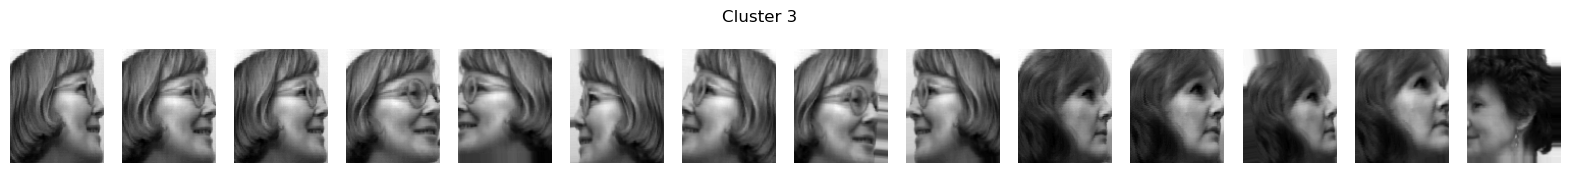

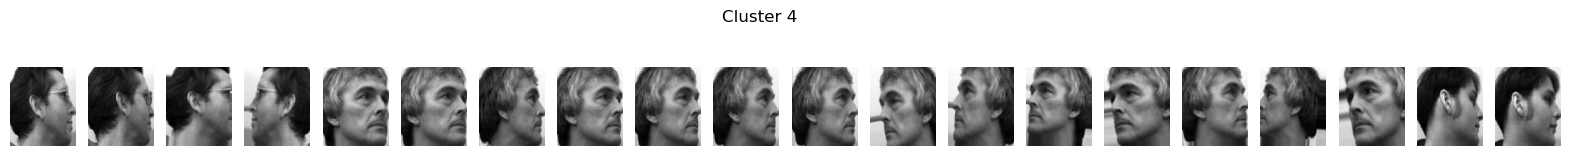

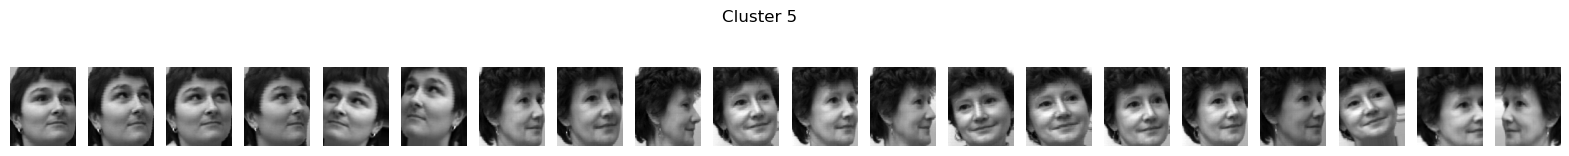

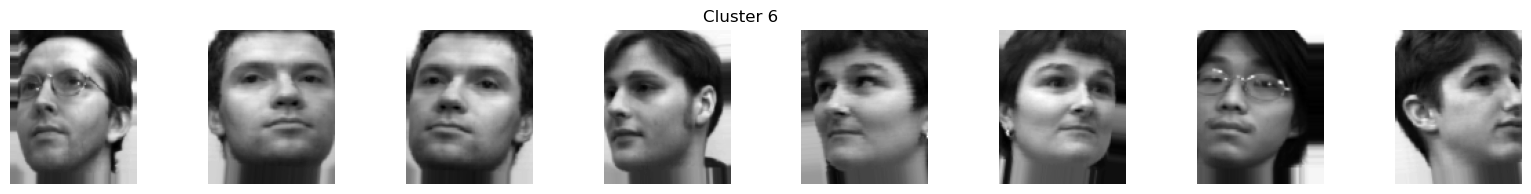

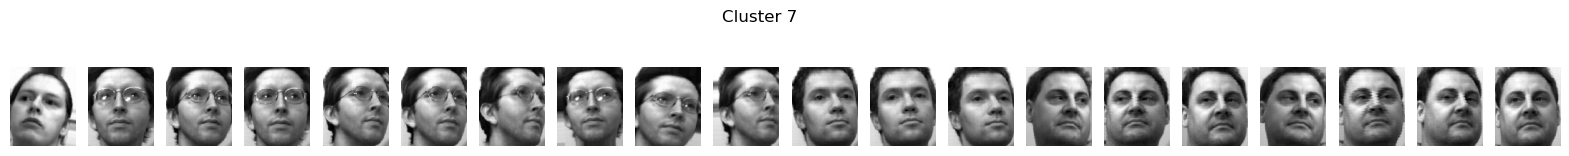

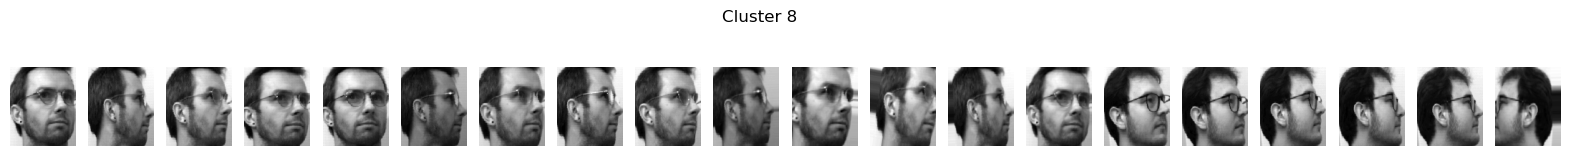

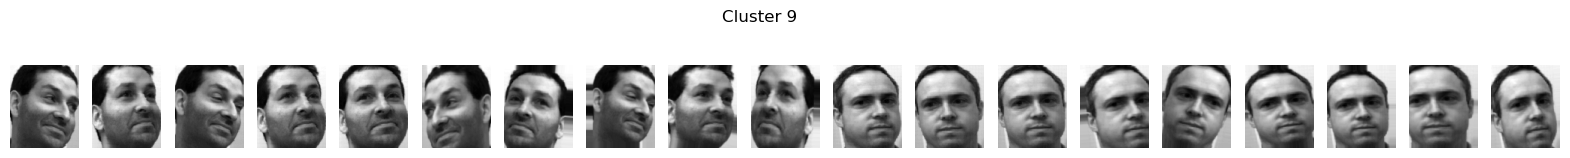

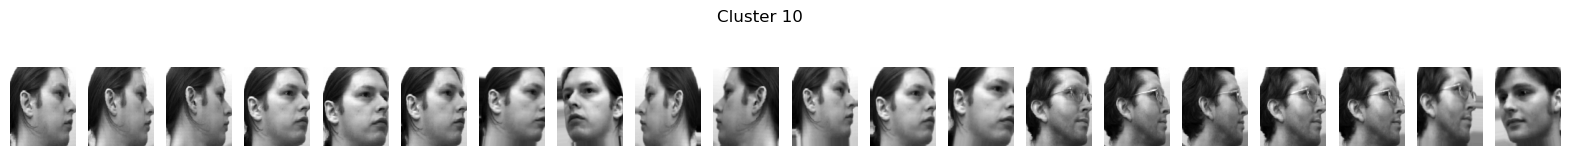

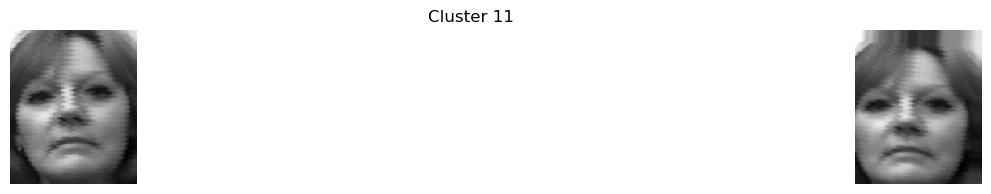

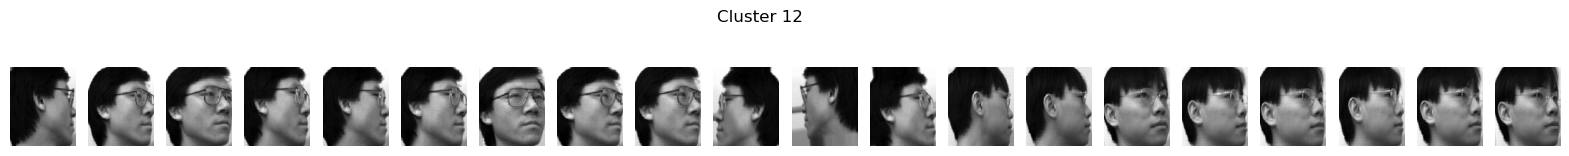

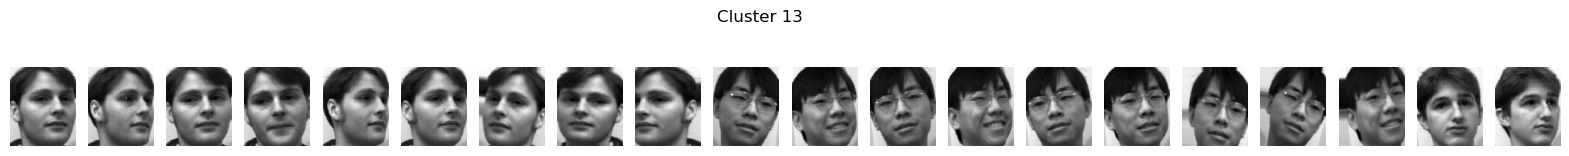

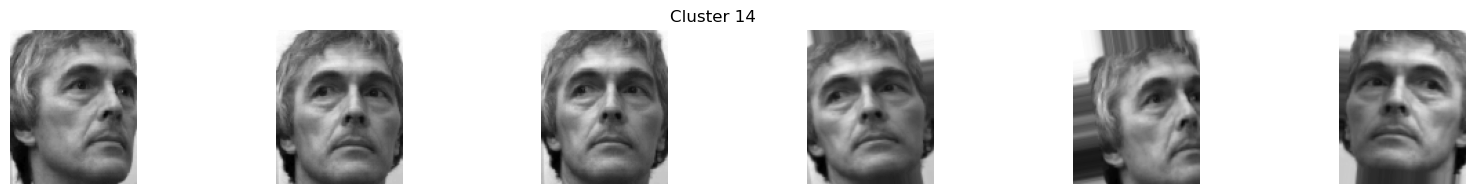

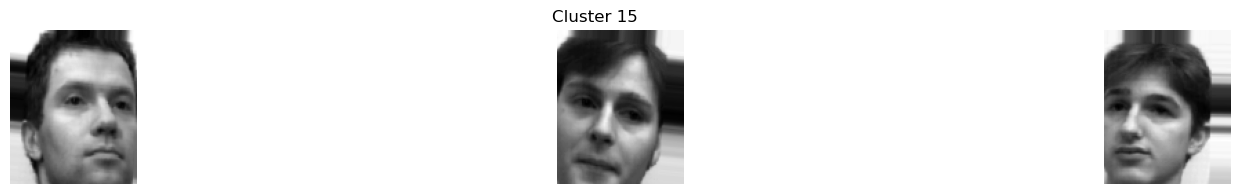

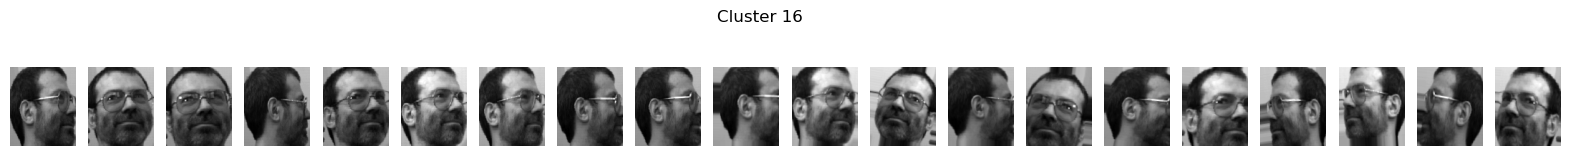

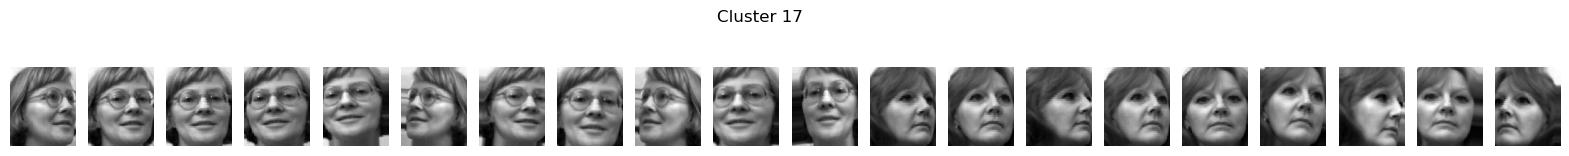

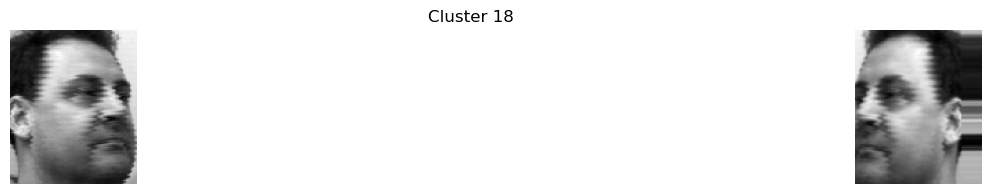

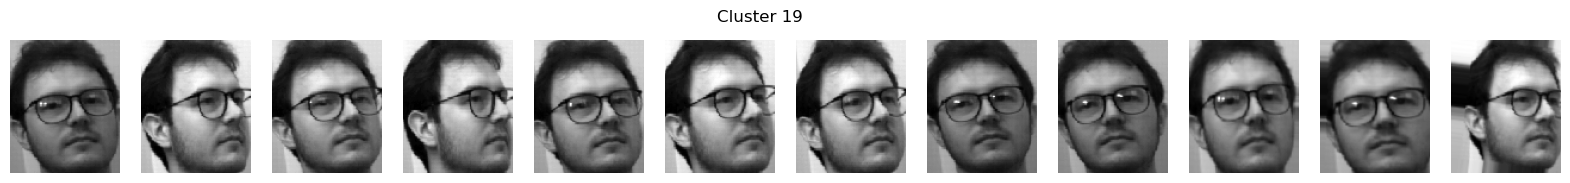

In [15]:
# Plot the first 10 images in each cluster
for cluster_id in range(21):
    # Get the indices of images in the current cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    
    # Determine the number of images to plot
    num_images = min(20, len(cluster_indices))
    
    if num_images > 0:
        fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
        
        for i in range(num_images):
            # Get the image index
            image_index = cluster_indices[i]
            
            # Get the image data
            image_data = umist_data.iloc[image_index].values
            
            # Reshape the image data
            image_data = image_data.reshape(112, 92)
            
            # Plot the image
            if num_images == 1:
                axes.imshow(image_data, cmap='gray')
                axes.axis('off')
            else:
                axes[i].imshow(image_data, cmap='gray')
                axes[i].axis('off')
            
        plt.suptitle(f"Cluster {cluster_id}")
        plt.show()

In [16]:
silhouette_score(X_train_rpca, cluster_labels, metric='cosine')

0.10659291690643252

In [17]:
umist_data['cluster_id'] = cluster_labels

umist_data.to_csv("umist_cropped_hierarchy_clustered.csv", index=False)